In [6]:
# Import Libraries
import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt

In [7]:
# File Paths
clean_test_file = './data/test.h5'
clean_valid_file = './data/valid.h5'
bad_test_file = './data/bd_test.h5'
bad_valid_file = './data/bd_valid.h5'
bad_net_file = './data/bd_net.h5'
bad_net_weights = './data/bd_weights.h5'

In [8]:
# Function to check if file exists
def check_file_exists(file_path):
    return os.path.exists(file_path)

# Checking each file
print(f"clean_test_file exists: {check_file_exists(clean_test_file)}")
print(f"clean_valid_file exists: {check_file_exists(clean_valid_file)}")
print(f"bad_test_file exists: {check_file_exists(bad_test_file)}")
print(f"bad_valid_file exists: {check_file_exists(bad_valid_file)}")
print(f"bad_net_file exists: {check_file_exists(bad_net_file)}")
print(f"bad_net_weights exists: {check_file_exists(bad_net_weights)}")

clean_test_file exists: True
clean_valid_file exists: True
bad_test_file exists: True
bad_valid_file exists: True
bad_net_file exists: True
bad_net_weights exists: True


In [9]:
# Create 'result' directory if not exists
result_directory = './result'
if not os.path.isdir(result_directory):
    os.mkdir(result_directory)

In [10]:
# Data Loader
def load_data(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0, 2, 3, 1))
    return x_data, y_data

# Data Preprocessor
def preprocess_data(x_data):
    return x_data / 255

# Load Net Model
def load_net_model(net_file):
    return keras.models.load_model(net_file)

# Load Network Weights
def load_weights(model, weights_file):
    model.load_weights(weights_file)
    print(f"Weights {weights_file} loaded for model {model}")

# Evaluate Backdoored Network Performance
def evaluate_origin(bd_model, cl_x_test, cl_y_test, bd_x_test, bd_y_test):
    cl_label_p = np.argmax(bd_model.predict(cl_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test)) * 100
    print('Clean Classification accuracy:', clean_accuracy)
    
    bd_label_p = np.argmax(bd_model.predict(bd_x_test), axis=1)
    attack_rate = np.mean(np.equal(bd_label_p, bd_y_test)) * 100
    print('Attack Success Rate:', attack_rate)
    return clean_accuracy

In [11]:
X_clean_valid, y_clean_valid = load_data(clean_valid_file)
X_bad_valid, y_bad_valid = load_data(bad_valid_file)

In [12]:
bd_model = load_net_model(bad_net_file)
load_weights(bd_model, bad_net_weights)
origin_acc = evaluate_origin(bd_model, X_clean_valid, y_clean_valid, X_bad_valid, y_bad_valid)

Weights ./data/bd_weights.h5 loaded for model <keras.src.engine.functional.Functional object at 0x293f89450>
361/361 [==============================] - 2s 4ms/step
Clean Classification accuracy: 98.64899974019225
361/361 [==============================] - 2s 5ms/step
Attack Success Rate: 100.0


In [ ]:
# Prune Channels
#You will design G using the pruning defense that we discussed in class. That is, you will prune the last pooling layer of BadNet B (the layer just before the FC layers) by removing one channel at a time from that layer. Channels should be removed in decreasing order of average activation values over the entire validation set. Every time you prune a channel, you will measure the new validation accuracy of the new pruned badnet. You will stop pruning once the validation accuracy drops atleast X% below the original accuracy. This will be your new network B'

bd_model.summary()

In [14]:
# Copy the backdoored model and find the specific layer to prune
prune_model = keras.models.clone_model(bd_model)
prune_model.load_weights(bad_net_weights)

# Prune the last pooling layer of BadNet B
activation_output = prune_model.layers[6].output
avg_activation = np.mean(keras.models.Model(inputs=prune_model.input, outputs=activation_output).predict(X_clean_valid), axis=(0, 1, 2))
sorted_avg_act_channel = np.argsort(avg_activation)

# Show the increasing order of activation values
print("Increasing order of average activation values")
print(avg_activation[sorted_avg_act_channel])

361/361 [==============================] - 1s 4ms/step
Increasing order of average activation values
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 3.0290761e-03 6.2408661e-03 1.3321567e-02 1.5006668e-02
 4.3979678e-02 8.3539166e-02 1.8378231e-01 2.4381575e-01 4.2763174e-01
 5.0732869e-01 5.3079778e-01 5.7658589e-01 8.5787809e-01 1.0589780e+00
 1.5654891e+00 1.6352932e+00 1.8540378e+00 2.0289583e+00 2.1106055e+00
 2.1980379e+00 3.6191158e+00 4.1488924e+00 4.8440871e+00 4.8648086e+00
 5.0868411e+00 5.1451392e+00 5.3690352e+00 6.2038708e+00 8.2229834e+00]


In [15]:
# Every time you prune a channel, measure the new validation accuracy
# Stop pruning once the validation accuracy drops at least X% below the original accuracy

print("The original accuracy is " + str(origin_acc))

The original accuracy is 98.64899974019225


In [17]:
X_prune_thresholds = np.array([2, 4, 10, 30])

In [20]:
# Prune Channels in increasing order
def prune_channels(prune_model, x_prune, x_clean, y_clean, x_bad, y_bad, save=False):
    w_h = prune_model.layers[5].get_weights()[0]
    b_h = prune_model.layers[5].get_weights()[1]

    acc_ori = np.mean(np.equal(np.argmax(prune_model.predict(x_clean), axis=1), y_clean)) * 100
    atk_ori = np.mean(np.equal(np.argmax(prune_model.predict(x_bad), axis=1), y_bad)) * 100

    acc_list, atk_list, prune_num_list = [], [], [0] * len(x_prune)

    for i, ch in enumerate(sorted_avg_act_channel):
        # Set and update w_h, b_h
        w_h[:, :, :, ch] = 0
        b_h[ch] = 0
        prune_model.layers[5].set_weights([w_h, b_h])

        # Predict and get the acc of the new network
        if abs(avg_activation[ch] - 0) < 1e-7:
            acc_tmp, atk_tmp = acc_ori, atk_ori
        else:
            acc_tmp = np.mean(np.equal(np.argmax(prune_model.predict(x_clean), axis=1), y_clean)) * 100
            atk_tmp = np.mean(np.equal(np.argmax(prune_model.predict(x_bad), axis=1), y_bad)) * 100

        acc_list.append(acc_tmp)
        atk_list.append(atk_tmp)
        print(f"{i + 1} channels pruned, acc = {acc_tmp}, atk = {atk_tmp}, X = {acc_ori - acc_tmp}")

        # Test and save the model if acc is X below the original acc
        if save:
            for j, threshold in enumerate(x_prune):
                if acc_ori - acc_tmp > threshold and prune_num_list[j] == 0:
                    prune_num_list[j] = i + 1
                    prune_model.save(f'{result_directory}/pruning_channel_model_acc_decrease_by_{threshold}%.h5')
                    print(f"Pruning channel model accuracy decrease by {threshold} saved at prune channels of {prune_num_list[j]}")

        keras.backend.clear_session()

    return acc_list, atk_list, prune_num_list

# ...

In [21]:
acc_prune, atk_prune, prune_num_prune = prune_channels(prune_model, X_prune_thresholds, X_clean_valid, y_clean_valid, X_bad_valid, y_bad_valid, save=True)

361/361 [==============================] - 2s 5ms/step
1 channels pruned, acc = 92.09318437689443, atk = 99.9913397419243, X = 0.0
2 channels pruned, acc = 92.09318437689443, atk = 99.9913397419243, X = 0.0
3 channels pruned, acc = 92.09318437689443, atk = 99.9913397419243, X = 0.0
4 channels pruned, acc = 92.09318437689443, atk = 99.9913397419243, X = 0.0
5 channels pruned, acc = 92.09318437689443, atk = 99.9913397419243, X = 0.0
6 channels pruned, acc = 92.09318437689443, atk = 99.9913397419243, X = 0.0
7 channels pruned, acc = 92.09318437689443, atk = 99.9913397419243, X = 0.0
8 channels pruned, acc = 92.09318437689443, atk = 99.9913397419243, X = 0.0
9 channels pruned, acc = 92.09318437689443, atk = 99.9913397419243, X = 0.0
10 channels pruned, acc = 92.09318437689443, atk = 99.9913397419243, X = 0.0
11 channels pruned, acc = 92.09318437689443, atk = 99.9913397419243, X = 0.0
12 channels pruned, acc = 92.09318437689443, atk = 99.9913397419243, X = 0.0
13 channels pruned, acc = 92.0

/Users/tharunk/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


361/361 [==============================] - 2s 5ms/step
52 channels pruned, acc = 84.43751623798389, atk = 77.015675067117, X = 7.655668138910542
Pruning channel model accuracy decrease by 4 saved at prune channels of 52
361/361 [==============================] - 2s 5ms/step
53 channels pruned, acc = 76.48739932449988, atk = 35.71490430414826, X = 15.605785052394552
Pruning channel model accuracy decrease by 10 saved at prune channels of 53
361/361 [==============================] - 2s 5ms/step
54 channels pruned, acc = 54.8627349095003, atk = 6.954187234779596, X = 37.23044946739413
Pruning channel model accuracy decrease by 30 saved at prune channels of 54
361/361 [==============================] - 2s 5ms/step
55 channels pruned, acc = 27.08928726076037, atk = 0.4243526457088421, X = 65.00389711613406
361/361 [==============================] - 2s 5ms/step
56 channels pruned, acc = 13.87373343725643, atk = 0.0, X = 78.219450939638
361/361 [==============================] - 2s 5ms/step


In [25]:
# Good Network
class GoodNetwork(keras.Model):
    def __init__(self, original_model, pruned_model):
        super(GoodNetwork, self).__init__()
        self.original_model = original_model
        self.pruned_model = pruned_model

    def predict(self, x):
        yhat_original = np.argmax(self.original_model.predict(x), axis=1)
        yhat_pruned = np.argmax(self.pruned_model.predict(x), axis=1)
        yhat_original[np.where(yhat_original != yhat_pruned)] = 1283
        return yhat_original

# 

In [26]:
# Combine Network B and Network B' to create the repaired network G
repaired_model_2p = GoodNetwork(bd_model, load_net_model(f'{result_directory}/pruning_channel_model_acc_decrease_by_2%.h5'))
repaired_model_4p = GoodNetwork(bd_model, load_net_model(f'{result_directory}/pruning_channel_model_acc_decrease_by_4%.h5'))
repaired_model_10p = GoodNetwork(bd_model, load_net_model(f'{result_directory}/pruning_channel_model_acc_decrease_by_10%.h5'))
repaired_model_30p = GoodNetwork(bd_model, load_net_model(f'{result_directory}/pruning_channel_model_acc_decrease_by_30%.h5'))

In [27]:
# Evaluation Function for Good Network
def evaluate_repaired(model, x_clean_test, y_clean_test, x_bad_test, y_bad_test):
    cl_label_p = model.predict(x_clean_test)
    clean_accuracy = np.mean(np.equal(cl_label_p, y_clean_test)) * 100
    print('Clean Classification accuracy:', clean_accuracy)

    bd_label_p = model.predict(x_bad_test)
    attack_rate = np.mean(np.equal(bd_label_p, y_bad_test)) * 100
    print('Attack Success Rate:', attack_rate)
    return clean_accuracy

# Load Test Data
X_clean_test, y_clean_test = load_data(clean_test_file)
X_bad_test, y_bad_test = load_data(bad_test_file)

# Compare the performance among original backdoored network and repaired networks
print("Backdoored network on the test dataset")
evaluate_origin(bd_model, X_clean_test, y_clean_test, X_bad_test, y_bad_test)

print("Repaired network, channels pruned with a 2% drop of accuracy, on the test dataset")
evaluate_repaired(repaired_model_2p, X_clean_test, y_clean_test, X_bad_test, y_bad_test)

print("Repaired network, channels pruned with a 4% drop of accuracy, on the test dataset")
evaluate_repaired(repaired_model_4p, X_clean_test, y_clean_test, X_bad_test, y_bad_test)

print("Repaired network, channels pruned with a 10% drop of accuracy, on the test dataset")
evaluate_repaired(repaired_model_10p, X_clean_test, y_clean_test, X_bad_test, y_bad_test)

print("Repaired network, channels pruned with a 30% drop of accuracy, on the test dataset")
evaluate_repaired(repaired_model_30p, X_clean_test, y_clean_test, X_bad_test, y_bad_test)

Backdoored network on the test dataset
401/401 [==============================] - 2s 5ms/step
Clean Classification accuracy: 98.62042088854248
401/401 [==============================] - 2s 5ms/step
Attack Success Rate: 100.0
Repaired network, channels pruned with a 2% drop of accuracy, on the test dataset
401/401 [==============================] - 2s 5ms/step
Clean Classification accuracy: 89.68043647700702
401/401 [==============================] - 2s 5ms/step
Attack Success Rate: 80.6469212782541
Repaired network, channels pruned with a 4% drop of accuracy, on the test dataset
401/401 [==============================] - 2s 5ms/step
Clean Classification accuracy: 84.3335931410756
401/401 [==============================] - 2s 5ms/step
Attack Success Rate: 77.20966484801247
Repaired network, channels pruned with a 10% drop of accuracy, on the test dataset
401/401 [==============================] - 2s 5ms/step
Clean Classification accuracy: 76.16523772408418
401/401 [=====================

54.67653936087296

401/401 [==============================] - 2s 5ms/step
1 channels pruned, acc = 98.62042088854248, atk = 100.0, X = 0.0
2 channels pruned, acc = 98.62042088854248, atk = 100.0, X = 0.0
3 channels pruned, acc = 98.62042088854248, atk = 100.0, X = 0.0
4 channels pruned, acc = 98.62042088854248, atk = 100.0, X = 0.0
5 channels pruned, acc = 98.62042088854248, atk = 100.0, X = 0.0
6 channels pruned, acc = 98.62042088854248, atk = 100.0, X = 0.0
7 channels pruned, acc = 98.62042088854248, atk = 100.0, X = 0.0
8 channels pruned, acc = 98.62042088854248, atk = 100.0, X = 0.0
9 channels pruned, acc = 98.62042088854248, atk = 100.0, X = 0.0
10 channels pruned, acc = 98.62042088854248, atk = 100.0, X = 0.0
11 channels pruned, acc = 98.62042088854248, atk = 100.0, X = 0.0
12 channels pruned, acc = 98.62042088854248, atk = 100.0, X = 0.0
13 channels pruned, acc = 98.62042088854248, atk = 100.0, X = 0.0
14 channels pruned, acc = 98.62042088854248, atk = 100.0, X = 0.0
15 channels pruned, acc = 98.6

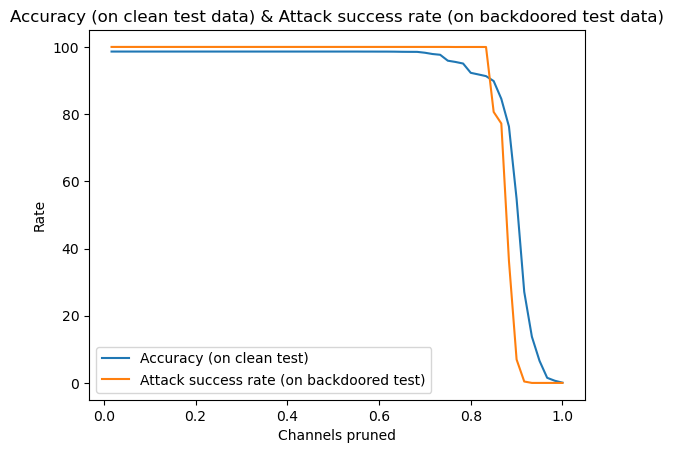

In [28]:
# Plot the accuracy on clean test data and the attack success rate on backdoored test data
prune_model_test = keras.models.clone_model(bd_model)
prune_model_test.load_weights(bad_net_weights)
acc_test, atk_test, prune_num_test = prune_channels(prune_model_test, X_prune_thresholds, X_clean_test, y_clean_test, X_bad_test, y_bad_test, save=False)


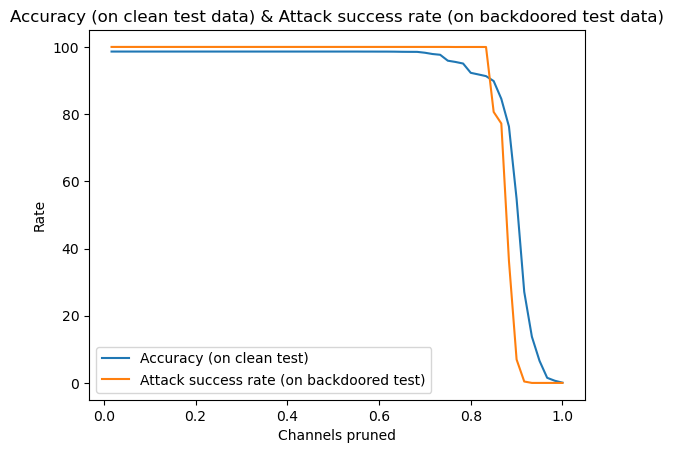

In [29]:
# The x-axis is actually from 1 to 60 and divided by 60
x_axis = np.arange(1, 61) / 60
plt.title("Accuracy (on clean test data) & Attack success rate (on backdoored test data)")
plt.xlabel("Channels pruned")
plt.ylabel("Rate")
plt.plot(x_axis, acc_test)
plt.plot(x_axis, atk_test)
plt.legend(['Accuracy (on clean test)', 'Attack success rate (on backdoored test)'])
plt.show()